<div align="center">

<img src="https://www.telecom-paris.fr/wp-content-EvDsK19/uploads/2024/01/logo_telecom_ipparis_rvb_fond_h.png" alt="Telecom Paris Logo" width="300"/>

---

# **Projet Big Data - EDA**
## *IADATA700 - Kit Big Data*

# 🍂 Analyse statistique / Recettes / Saisonnalité

In [24]:
import sys
sys.path.append('..')

# Forcer le rechargement de notre module
from _data_utils import *

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import warnings

from scipy import stats
from scipy.stats import spearmanr, kendalltau, kruskal, chi2_contingency, chisquare, kstest
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

if '_data_utils' in sys.modules:
    import _data_utils
    importlib.reload(_data_utils)
    if hasattr(_data_utils, 'data_utils_recipes'):
        importlib.reload(_data_utils.data_utils_recipes)

warnings.filterwarnings('ignore')

# Configuration graphique
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Import réussi !")

✅ _data_utils module chargé (common + ratings + recipes)
✅ Import réussi !


## 📥 Chargement des données

In [18]:
# 🚀 Pipeline complet : charge + nettoie + enrichit
df = load_clean_recipes()

print(f"✅ Dataset prêt : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"📅 Période : {df['year'].min()} - {df['year'].max()}")

# 📊 Rapport de qualité
report = analyze_recipe_quality(df)

✅ RAW_RECIPES chargée : 231,637 lignes × 12 colonnes
🧹 Nettoyage des recettes...
   ✓ 18,482 recettes avec minutes invalides (<1 ou >180)
   ℹ️  Seuils calculés (IQ 90% = Q5%-Q95%):
      • n_steps: [2, 24] (médiane=9, moyenne=9.7)
      • n_ingredients: [3, 17] (médiane=9, moyenne=9.0)
   ✓ 13,088 recettes avec n_steps ou n_ingredients aberrants (hors IQ 90%)
✅ Nettoyage terminé : 200,066 recettes conservées (31,571 supprimées)
⚙️ Enrichissement des recettes...
✅ Enrichissement terminé : 28 colonnes totales
✅ Dataset prêt : 200,066 lignes × 28 colonnes
📅 Période : 1999 - 2018
📊 Analyse de qualité des données...
✅ Nettoyage terminé : 200,066 recettes conservées (31,571 supprimées)
⚙️ Enrichissement des recettes...
✅ Enrichissement terminé : 28 colonnes totales
✅ Dataset prêt : 200,066 lignes × 28 colonnes
📅 Période : 1999 - 2018
📊 Analyse de qualité des données...

📋 RAPPORT DE QUALITÉ - RAW_RECIPES
📦 Dimensions : 200,066 lignes × 28 colonnes
🔄 Doublons : 0
⚠️  Valeurs nulles :
   • de

## Analyse statistique

### Analyse 1 : Évolution du volume de recettes
#### Visualisation

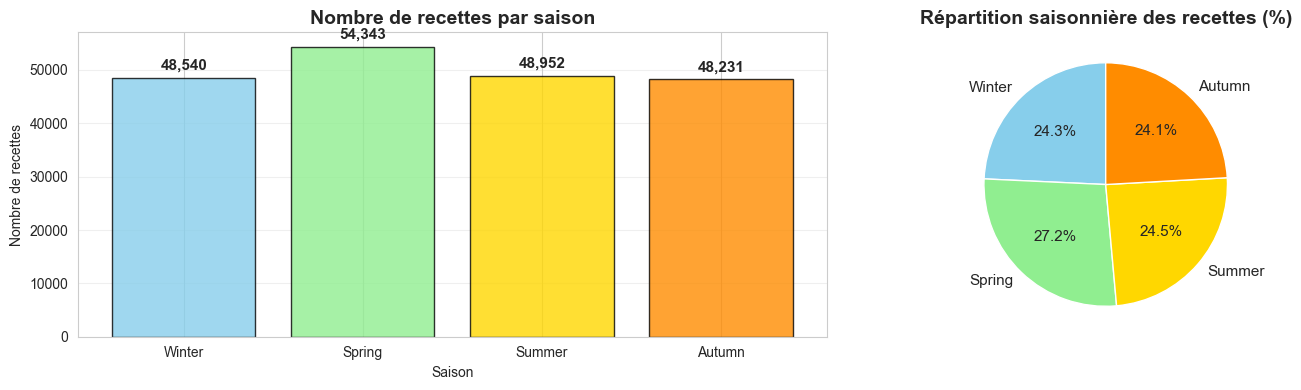

In [3]:
recipes_per_season = (df.group_by("season").agg(pl.len().alias("n_recipes")).sort("season").to_pandas())

# Visualization
season_order = ["Winter", "Spring", "Summer", "Autumn"]
season_colors = {"Winter": "#87CEEB", "Spring": "#90EE90", "Summer": "#FFD700", "Autumn": "#FF8C00"}
recipes_per_season = recipes_per_season.set_index('season').loc[season_order].reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

colors = [season_colors[season] for season in recipes_per_season['season']]
bars = ax1.bar(recipes_per_season['season'], recipes_per_season['n_recipes'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Nombre de recettes par saison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Saison')
ax1.set_ylabel('Nombre de recettes')
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, recipes_per_season['n_recipes']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{val:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

sizes = recipes_per_season['n_recipes']
labels = recipes_per_season['season']
colors_pie = [season_colors[season] for season in recipes_per_season['season']]
wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%',
                                   startangle=90, textprops={'fontsize': 11})
ax2.set_title('Répartition saisonnière des recettes (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

#### Tests statistique et interprétation

In [4]:
observed = recipes_per_season['n_recipes'].values
expected_uniform = [recipes_per_season['n_recipes'].sum() / 4] * 4

chi2_stat, chi2_p = chisquare(observed, expected_uniform)
print(f"Test Chi-2 (uniformité): χ² = {chi2_stat:.4f} (p = {chi2_p:.6f})")
print(f"Répartition uniforme: {'❌ Rejetée' if chi2_p < 0.05 else '✅ Acceptée'}")

mean_recipes = recipes_per_season['n_recipes'].mean()
std_recipes = recipes_per_season['n_recipes'].std()
cv = (std_recipes / mean_recipes) * 100

print(f"\nVariabilité saisonnière:")
print(f"   • Moyenne: {mean_recipes:.0f} recettes/saison")
print(f"   • Écart-type: {std_recipes:.0f} recettes")
print(f"   • Coefficient de variation: {cv:.1f}%")

print(f"\n🔍 ÉCARTS PAR RAPPORT À LA MOYENNE:")
print("-" * 50)

for _, row in recipes_per_season.iterrows():
    season_fr = row['season']
    count = int(row['n_recipes'])
    deviation = count - mean_recipes
    deviation_pct = (deviation / mean_recipes) * 100
    status = "📈" if deviation > 0 else "📉" if deviation < -std_recipes else "➡️"
    print(f"{status} {season_fr:>12}: {count:>7,} ({deviation:+6.0f}, {deviation_pct:+5.1f}%)")


Test Chi-2 (uniformité): χ² = 504.2301 (p = 0.000000)
Répartition uniforme: ❌ Rejetée

Variabilité saisonnière:
   • Moyenne: 50016 recettes/saison
   • Écart-type: 2899 recettes
   • Coefficient de variation: 5.8%

🔍 ÉCARTS PAR RAPPORT À LA MOYENNE:
--------------------------------------------------
➡️       Winter:  48,540 ( -1476,  -3.0%)
📈       Spring:  54,343 ( +4326,  +8.7%)
➡️       Summer:  48,952 ( -1064,  -2.1%)
➡️       Autumn:  48,231 ( -1786,  -3.6%)


> **💡 Interprétation statistique:** 
>  
> Le **test du χ²** montre que la **répartition saisonnière** du nombre de recettes **n’est pas uniforme**, avec des **écarts significatifs** entre les saisons.  
>
> Le **printemps**, nettement au-dessus de la moyenne, indique une **saisonnalité marquée** dans la production, tandis que les autres saisons restent **relativement stables**.  
>
> Cette **surreprésentation printanière** explique le **rejet de l’uniformité** et souligne une **tendance saisonnière modérée** mais **statistiquement significative**.


> **💡 Interprétation business:** 
>  
> Le **test du χ²** montre que la **répartition saisonnière** du nombre de recettes **n’est pas uniforme**, avec des **écarts significatifs** entre les saisons.  
>
> Le **printemps**, nettement au-dessus de la moyenne, indique une **saisonnalité marquée** dans la production, tandis que les autres saisons restent **relativement stables**.  
>
> Cette **surreprésentation printanière** explique le **rejet de l’uniformité** et souligne une **tendance saisonnière modérée** mais **statistiquement significative**.


### Analyse 2: Évolution de la durée moyenne
#### Visualisation

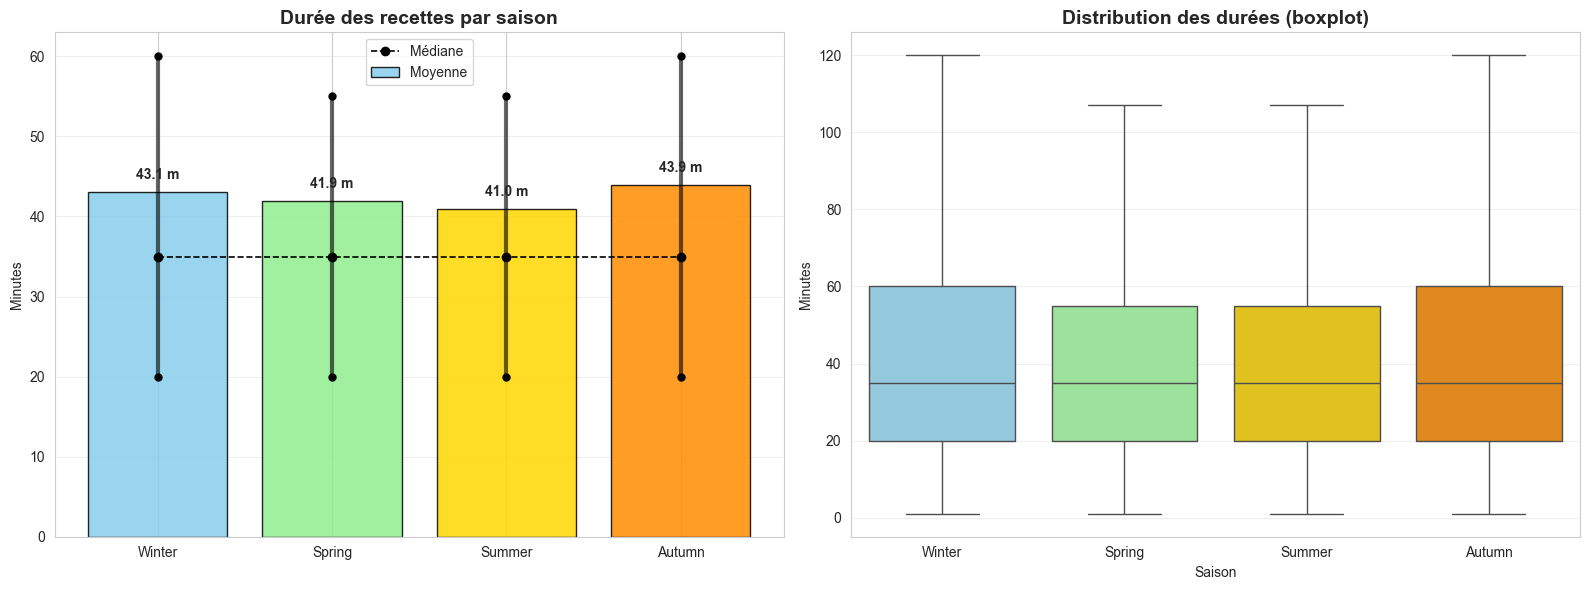

In [5]:
minutes_by_season = (df.group_by("season")
    .agg([
        pl.mean("minutes").alias("mean_minutes"), pl.median("minutes").alias("median_minutes"),
        pl.quantile("minutes",0.25).alias("q25"), pl.quantile("minutes",0.75).alias("q75"), pl.len().alias("n_recipes")
    ]).sort("season").to_pandas().set_index("season").loc[season_order].reset_index())
minutes_by_season["IQR"] = minutes_by_season["q75"] - minutes_by_season["q25"]

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
bar_colors=[season_colors[s] for s in minutes_by_season.season]
ax1.bar(minutes_by_season.season, minutes_by_season.mean_minutes, color=bar_colors, alpha=.85, edgecolor='black', lw=1,label='Moyenne')
ax1.plot(minutes_by_season.season, minutes_by_season.median_minutes, 'o--', color='black', lw=1.2, ms=6,label='Médiane')
for s,m,med,q25,q75,_n,_iqr in minutes_by_season[['season','mean_minutes','median_minutes','q25','q75','n_recipes','IQR']].itertuples(index=False):
    ax1.vlines(s,q25,q75,color='black',lw=3,alpha=.6); ax1.scatter([s],[q25],color='black',s=25); ax1.scatter([s],[q75],color='black',s=25)
    ax1.text(s,m*1.03,f"{m:.1f} m",ha='center',va='bottom',fontsize=10,fontweight='bold')
ax1.set_title("Durée des recettes par saison",fontsize=14,fontweight='bold'); ax1.set_ylabel("Minutes"); ax1.grid(axis='y',alpha=.3); ax1.legend()

sns.boxplot(data=df.to_pandas(), x='season', y='minutes', order=season_order,
            palette=[season_colors[s] for s in season_order], ax=ax2, showfliers=False)
ax2.set_title("Distribution des durées (boxplot)",fontsize=14,fontweight='bold'); ax2.set_xlabel("Saison"); ax2.set_ylabel("Minutes"); ax2.grid(axis='y',alpha=.3)

plt.tight_layout(); 
plt.show()

#### Tests statistique et interprétation

In [6]:
# Résumé + Test Kruskal 
print("\nRésumé statistique par saison (minutes):\n" + "-"*55)
for s,m,med,q25,q75,iqr,n in minutes_by_season[['season','mean_minutes','median_minutes','q25','q75','IQR','n_recipes']].itertuples(index=False):
    print(f"{s:<8} | Moy:{m:6.1f} | Med:{med:6.1f} | Q25:{q25:6.1f} | Q75:{q75:6.1f} | IQR:{iqr:6.1f} | n={n:,}")
    
kw_stat, kw_p = kruskal(*[df.to_pandas().query('season==@s')['minutes'].values for s in season_order])
print(f"\nKruskal-Wallis: H={kw_stat:.3f}, p={kw_p:.6f}")
print(f"Différences significatives" if kw_p<0.05 else "Pas de différence nette")


Résumé statistique par saison (minutes):
-------------------------------------------------------
Winter   | Moy:  43.1 | Med:  35.0 | Q25:  20.0 | Q75:  60.0 | IQR:  40.0 | n=48,540
Spring   | Moy:  41.9 | Med:  35.0 | Q25:  20.0 | Q75:  55.0 | IQR:  35.0 | n=54,343
Summer   | Moy:  41.0 | Med:  35.0 | Q25:  20.0 | Q75:  55.0 | IQR:  35.0 | n=48,952
Autumn   | Moy:  43.9 | Med:  35.0 | Q25:  20.0 | Q75:  60.0 | IQR:  40.0 | n=48,231

Kruskal-Wallis: H=346.926, p=0.000000
Différences significatives

Kruskal-Wallis: H=346.926, p=0.000000
Différences significatives


> **💡 Interprétation :**  
> 
> Le **test de Kruskal-Wallis** (H = 346.93, p < 0.001) confirme des **différences significatives** de durée entre les saisons.  
> 
> Les recettes sont **plus longues en automne (43.9 min)** et en **hiver (43.1 min)**, tandis qu’elles sont **plus courtes en été (41.0 min)**.  
> 
> Cette tendance indique que les **recettes postées en périodes froides** demandent en moyenne **plus de temps de préparation**, alors que **les recettes estivales** sont **plus rapides**, probablement associées à des plats **plus simples ou légers**.  


### Analyse 3: Évolution de la complexité
#### Visualisation

In [23]:
# Data: score = log1p(minutes) + n_steps + 0.5 * n_ingredients
comp_season_year = (df.group_by(["year", "season"])\
    .agg([pl.mean("complexity_score").alias("mean_complexity"),
           pl.median("complexity_score").alias("median_complexity"),
           pl.std("complexity_score").alias("std_complexity"),
           pl.len().alias("n")])\n
    .sort(["year", "season"]).to_pandas())

pivot_mc = comp_season_year.pivot(index="year", columns="season", values="mean_complexity")[season_order]

fig, ax = plt.subplots(figsize=(14,5))
for s in season_order:
    ax.plot(pivot_mc.index, pivot_mc[s], marker='o', linewidth=2, label=s, color=season_colors[s])
ax.set_title("Évolution de la complexité moyenne par saison", fontsize=14, fontweight='bold')
ax.set_xlabel("Année"); ax.set_ylabel("Complexity Score")
years_int = [int(y) for y in pivot_mc.index]
ax.set_xticks(pivot_mc.index)
ax.set_xticklabels(years_int, rotation=45)

ax.grid(alpha=0.3); ax.legend(ncol=4)
plt.tight_layout(); plt.show()

SyntaxError: unexpected character after line continuation character (1023206839.py, line 6)

#### Tests statistique et interprétation

In [20]:
# ANOVA factorielle: complexity_score ~ C(season) * year
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import polars as pl

# Préparer un DataFrame pandas propre
season_df = df.select([
    pl.col('complexity_score'),
    pl.col('season'),
    pl.col('year').cast(pl.Int32, strict=False)
]).to_pandas()
season_df['year'] = pd.to_numeric(season_df['year'], errors='coerce').astype(int)

model_season = smf.ols('complexity_score ~ C(season) * year', data=season_df).fit()
anova_season = sm.stats.anova_lm(model_season, typ=2)

# Effets de taille
ss_total = anova_season['sum_sq'].sum()
ss_error = anova_season.loc['Residual','sum_sq']
anova_season['eta_sq'] = anova_season['sum_sq'] / ss_total
anova_season['partial_eta_sq'] = anova_season['sum_sq'] / (anova_season['sum_sq'] + ss_error)
print(anova_season[['sum_sq','df','F','PR(>F)','eta_sq','partial_eta_sq']])

p_main = anova_season.loc['C(season)','PR(>F)']
p_inter = anova_season.loc['C(season):year','PR(>F)']
eta_main = anova_season.loc['C(season)','eta_sq']
eta_inter = anova_season.loc['C(season):year','eta_sq']
pet_main = anova_season.loc['C(season)','partial_eta_sq']
pet_inter = anova_season.loc['C(season):year','partial_eta_sq']

print("\nRésumé:")
print(f"Effet saison: p={p_main:.3g} | eta²={eta_main:.4f} | η²_partiel={pet_main:.4f} -> {'Différences de niveaux ✅' if p_main<0.05 else 'Pas de différence ❌'}")
print(f"Interaction saison*année: p={p_inter:.3g} | eta²={eta_inter:.4f} | η²_partiel={pet_inter:.4f} -> {'Pentes différentes ✅' if p_inter<0.05 else 'Pentes similaires ❌'}")

# Extraction des pentes par saison si interaction
if p_inter < 0.05:
    print("\nPentes temporelles par saison (Δ complexity/an):")
    ref = sorted(season_df['season'].unique())[0]
    base_slope = model_season.params['year']
    print(f"  {ref}: {base_slope:.4f} (référence)")
    for s in sorted(season_df['season'].unique()):
        if s == ref: continue
        term = f"C(season)[T.{s}]:year"
        slope = base_slope + model_season.params.get(term,0.0)
        print(f"  {s}: {slope:.4f}")
else:
    global_slope = model_season.params.get('year', float('nan'))
    print(f"\nPente globale (unique): {global_slope:.4f} pts/an")

# Petit résumé des niveaux moyens par saison (centré sur complexité)
mean_levels = season_df.groupby('season')['complexity_score'].mean().sort_values()
print("\nNiveaux moyens de complexité par saison:")
for s,v in mean_levels.items():
    print(f"  {s:<7}: {v:.3f}")

                      sum_sq        df           F         PR(>F)    eta_sq  \
C(season)       7.033606e+03       3.0   67.124511   2.239499e-43  0.001003   
year            1.821307e+04       1.0  521.443716  2.886138e-115  0.002597   
C(season):year  5.894067e+02       3.0    5.624944   7.501299e-04  0.000084   
Residual        6.987656e+06  200058.0         NaN            NaN  0.996316   

                partial_eta_sq  
C(season)             0.001006  
year                  0.002600  
C(season):year        0.000084  
Residual              0.500000  

Résumé:
Effet saison: p=2.24e-43 | eta²=0.0010 | η²_partiel=0.0010 -> Différences de niveaux ✅
Interaction saison*année: p=0.00075 | eta²=0.0001 | η²_partiel=0.0001 -> Pentes différentes ✅

Pentes temporelles par saison (Δ complexity/an):
  Autumn: 0.1253 (référence)
  Spring: 0.0762
  Summer: 0.0997
  Winter: 0.1137

Niveaux moyens de complexité par saison:
  Summer : 16.821
  Spring : 17.052
  Winter : 17.223
  Autumn : 17.283


In [22]:
# ANOVA factorielle (version concise)
# Suppose que les variables suivantes existent déjà dans le notebook :
# anova_tbl (table complète), eta_season, pet_season, eta_main, pet_main, eta_inter, pet_inter
# Si elles n'existent pas (exécution isolée), on les (re)calcule rapidement.

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

needed = [
    'anova_tbl','eta_season','pet_season','eta_main','pet_main','eta_inter','pet_inter'
]
missing = [v for v in needed if v not in globals()]
if missing:
    # Recalcule minimal à partir de df_anova ou reconstruction depuis df (polars)
    if 'df_anova' not in globals():
        # fallback conversion
        if 'df' in globals():
            df_anova = df.select([
                'complexity_score','season','year'
            ]).to_pandas()
        else:
            raise RuntimeError("Impossible de recalculer: données sources absentes.")
    model_season = smf.ols('complexity_score ~ C(season) * year', data=df_anova).fit()
    anova_tbl = sm.stats.anova_lm(model_season, typ=2)
    # Effets (eta²) & eta² partiels
    ss_res = anova_tbl.loc['Residual','sum_sq']
    total_ss = anova_tbl['sum_sq'].sum()
    def eta_sq(term):
        return anova_tbl.loc[term,'sum_sq'] / total_ss
    def pet_eta_sq(term):
        return anova_tbl.loc[term,'sum_sq'] / (anova_tbl.loc[term,'sum_sq'] + ss_res)
    eta_season = eta_sq('C(season)')
    pet_season = pet_eta_sq('C(season)')
    eta_main = eta_sq('year')
    pet_main = pet_eta_sq('year')
    eta_inter = eta_sq('C(season):year')
    pet_inter = pet_eta_sq('C(season):year')

# Construction d'un résumé compact
rows = []
for label, eta, peta in [
    ('Saison', eta_season, pet_season),
    ('Année', eta_main, pet_main),
    ('Interaction', eta_inter, pet_inter)
]:
    # Map vers les bons index de la table anova
    idx_map = {
        'Saison': 'C(season)',
        'Année': 'year',
        'Interaction': 'C(season):year'
    }
    term = idx_map[label]
    F_val = anova_tbl.loc[term,'F']
    p_val = anova_tbl.loc[term,'PR(>F)']
    rows.append({
        'Effet': label,
        'F': F_val,
        'p': p_val,
        'eta_sq': eta,
        'partial_eta_sq': peta
    })
compact = pd.DataFrame(rows)

# Formatage lisible
compact_fmt = compact.copy()
compact_fmt['F'] = compact_fmt['F'].map(lambda x: f"{x:.2f}")
compact_fmt['p'] = compact_fmt['p'].map(lambda x: f"{x:.2e}")
compact_fmt['eta_sq'] = compact_fmt['eta_sq'].map(lambda x: f"{x:.4f}")
compact_fmt['partial_eta_sq'] = compact_fmt['partial_eta_sq'].map(lambda x: f"{x:.4f}")

print("ANOVA complexité (résumé non verbeux) :")
print(compact_fmt.to_string(index=False))

# Mini interprétation automatique (optionnel)
THRESHOLD = 0.01  # seuil arbitraire pour remarquer des effets pratiques
notes = []
for _, r in compact.iterrows():
    flag = "faible" if r['partial_eta_sq'] < THRESHOLD else "modéré"
    notes.append(f"{r['Effet']}: p={r['p']:.2e}, partial_eta²={r['partial_eta_sq']:.4f} ({flag})")
print("\nRésumé:")
print(" | ".join(notes))

# Expose aussi la DataFrame brute si besoin en aval
anova_compact = compact


ANOVA complexité (résumé non verbeux) :
      Effet      F         p eta_sq partial_eta_sq
     Saison  67.12  2.24e-43 0.0010         0.0010
      Année 521.44 2.89e-115 0.0010         0.0010
Interaction   5.62  7.50e-04 0.0001         0.0001

Résumé:
Saison: p=2.24e-43, partial_eta²=0.0010 (faible) | Année: p=2.89e-115, partial_eta²=0.0010 (faible) | Interaction: p=7.50e-04, partial_eta²=0.0001 (faible)


> **💡 Interprétation statistique (Complexité & Saisonnalité)**  
>  
> Résultats ANOVA factorielle (complexity_score ~ saison * année) :  
> • Effet principal saison significatif (p = 2.2e-43) mais η² ≈ 0.001 → la saison explique <0.1% de la variance totale (effet très faible).  
> • Effet année très significatif (p ≈ 2.9e-115), η² ≈ 0.0026 → légère tendance générale à la hausse avec le temps.  
> • Interaction saison*année significative (p ≈ 7.5e-04) mais η² ≈ 0.00008 → les pentes diffèrent statistiquement mais l'effet est minuscule en pratique.  
>  
> Pentes annuelles estimées (Δ complexité / an) :  
> • Autumn: +0.1253  
> • Winter: +0.1137  
> • Summer: +0.0997  
> • Spring: +0.0762  
>  
> Niveaux moyens (complexité moyenne) : Summer (16.82) < Spring (17.05) < Winter (17.22) < Autumn (17.28).  
>  
> ✅ Interprétation : La complexité des recettes augmente dans toutes les saisons mais un peu plus vite en automne/hiver. Les différences entre saisons existent (classement cohérent) mais les tailles d'effet sont extrêmement faibles → la significativité provient surtout du volume massif de données.  
>  
> 🎯 Implication pratique : Pour la modélisation ou la recommandation, la saison pourrait être incluse comme feature mais son pouvoir explicatif isolé est marginal. Le temps (année) reflète surtout une évolution structurelle (qualité, richesse des recettes).  
>  
> 🔎 Suites possibles : post-hoc (Tukey) pour confirmer ordres; décomposition du score (n_ingredients, n_steps, minutes) pour voir quel composant entraîne la hausse; modèle mixte avec aléa année si hétérogénéité résiduelle.  
>  
> ℹ️ Remarque : éviter de sur-interpréter des différences de très faible amplitude sans mise en perspective (ex: représentation graphique des tailles d'effet).

### Analyse 5: Évolution des ingrédients
#### Visualisation

#### Tests statistique et interprétation

### Analyse 6: Évolution des tags
#### Visualisation

#### Tests statistique et interprétation